<a href="https://colab.research.google.com/github/UdayPuligilla/AI-Driven-Insights-Machine-Learning-Models-for-Chronic-Kidney-Disease-Prediction/blob/main/LimeExplanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
# Import the library to mount Google Drive
from google.colab import drive
# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/Chronic kidney disease/chronic_kidney_disease (1).csv'
ckd_data = pd.read_csv(file_path)
ckd_data.head()

age    bp     sg   al   su     rbc        pc         pcc          ba  \
0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

     bgr  ...   pcv    wbcc  rbcc  htn   dm  cad  appet   pe  ane class  
0  121.0  ...  44.0  7800.0   5.2  yes  yes   no   good   no   no   ckd  
1    NaN  ...  38.0  6000.0   NaN   no   no   no   good   no   no   ckd  
2  423.0  ...  31.0  7500.0   NaN   no  yes   no   poor   no  yes   ckd  
3  117.0  ...  32.0  6700.0   3.9  yes   no   no   poor  yes  yes   ckd  
4  106.0  ...  35.0  7300.0   4.6   no   no   no   good   no   no   ckd  

[5 rows x 25 columns]

In [4]:
ckd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

In [5]:
column_mapping = {
    'age': 'Age',
    'bp': 'Blood Pressure',
    'sg': 'Specific Gravity',
    'al': 'Albumin',
    'su': 'Sugar',
    'rbc': 'Red Blood Cells',
    'pc': 'Pus Cell',
    'pcc': 'Pus Cell Clumps',
    'ba': 'Bacteria',
    'bgr': 'Blood Glucose Random',
    'bu': 'Blood Urea',
    'sc': 'Serum Creatinine',
    'sod': 'Sodium',
    'pot': 'Potassium',
    'hemo': 'Hemoglobin',
    'pcv': 'Packed Cell Volume',
    'wbcc': 'White Blood Cell Count',
    'rbcc': 'Red Blood Cell Count',
    'htn': 'Hypertension',
    'dm': 'Diabetes Mellitus',
    'cad': 'Coronary Artery Disease',
    'appet': 'Appetite',
    'pe': 'Pedal Edema',
    'ane': 'Anemia',
    'class': 'CKD Stage'  # Assuming 'class' indicates CKD presence or stage.
}
# Rename columns
ckd_data = ckd_data.rename(columns=column_mapping)

# Verify changes
print(ckd_data.columns)


Index(['Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar',
       'Red Blood Cells', 'Pus Cell', 'Pus Cell Clumps', 'Bacteria',
       'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine', 'Sodium',
       'Potassium', 'Hemoglobin', 'Packed Cell Volume',
       'White Blood Cell Count', 'Red Blood Cell Count', 'Hypertension',
       'Diabetes Mellitus', 'Coronary Artery Disease', 'Appetite',
       'Pedal Edema', 'Anemia', 'CKD Stage'],
      dtype='object')


In [6]:
categorical_features = ckd_data.select_dtypes(include=['object']).columns
numerical_features = ckd_data.select_dtypes(include=['float', 'int']).columns

print("Unique values in categorical features:")
for col in categorical_features:
    unique_values = ckd_data[col].unique()
    print(f"{col}: {unique_values}")

print("\nNumerical features and their value ranges:")
for col in numerical_features:
    min_value = ckd_data[col].min()
    max_value = ckd_data[col].max()
    unique_values_count = ckd_data[col].nunique()

    print(f"{col}: Range = ({min_value}, {max_value}), Unique values count = {unique_values_count}")


Unique values in categorical features:
Red Blood Cells: [nan 'normal' 'abnormal']
Pus Cell: ['normal' 'abnormal' nan]
Pus Cell Clumps: ['notpresent' 'present' nan]
Bacteria: ['notpresent' 'present' nan]
Hypertension: ['yes' 'no' nan]
Diabetes Mellitus: ['yes' 'no' '\tno' nan]
Coronary Artery Disease: ['no' 'yes' nan]
Appetite: ['good' 'poor' nan]
Pedal Edema: ['no' 'yes' nan]
Anemia: ['no' 'yes' nan]
CKD Stage: ['ckd' 'ckd\t' 'notckd']

Numerical features and their value ranges:
Age: Range = (2.0, 90.0), Unique values count = 76
Blood Pressure: Range = (50.0, 180.0), Unique values count = 10
Specific Gravity: Range = (1.005, 1.025), Unique values count = 5
Albumin: Range = (0.0, 5.0), Unique values count = 6
Sugar: Range = (0.0, 5.0), Unique values count = 6
Blood Glucose Random: Range = (22.0, 490.0), Unique values count = 146
Blood Urea: Range = (1.5, 391.0), Unique values count = 118
Serum Creatinine: Range = (0.4, 76.0), Unique values count = 84
Sodium: Range = (4.5, 163.0), Unique

In [7]:
ckd_data['CKD Stage'] = ckd_data['CKD Stage'].replace('ckd\t', 'ckd')
print(ckd_data['CKD Stage'].value_counts())
ckd_data['Diabetes Mellitus'] = ckd_data['Diabetes Mellitus'].replace('\tno', 'no')

CKD Stage
ckd       250
notckd    150
Name: count, dtype: int64


In [8]:
categorical_features = ckd_data.select_dtypes(include=['object']).columns
numerical_features = ckd_data.select_dtypes(include=['float', 'int']).columns

print("Unique values in categorical features:")
for col in categorical_features:
    unique_values = ckd_data[col].unique()
    print(f"{col}: {unique_values}")

print("\nNumerical features and their value ranges:")
for col in numerical_features:
    min_value = ckd_data[col].min()
    max_value = ckd_data[col].max()
    unique_values_count = ckd_data[col].nunique()

    print(f"{col}: Range = ({min_value}, {max_value}), Unique values count = {unique_values_count}")


Unique values in categorical features:
Red Blood Cells: [nan 'normal' 'abnormal']
Pus Cell: ['normal' 'abnormal' nan]
Pus Cell Clumps: ['notpresent' 'present' nan]
Bacteria: ['notpresent' 'present' nan]
Hypertension: ['yes' 'no' nan]
Diabetes Mellitus: ['yes' 'no' nan]
Coronary Artery Disease: ['no' 'yes' nan]
Appetite: ['good' 'poor' nan]
Pedal Edema: ['no' 'yes' nan]
Anemia: ['no' 'yes' nan]
CKD Stage: ['ckd' 'notckd']

Numerical features and their value ranges:
Age: Range = (2.0, 90.0), Unique values count = 76
Blood Pressure: Range = (50.0, 180.0), Unique values count = 10
Specific Gravity: Range = (1.005, 1.025), Unique values count = 5
Albumin: Range = (0.0, 5.0), Unique values count = 6
Sugar: Range = (0.0, 5.0), Unique values count = 6
Blood Glucose Random: Range = (22.0, 490.0), Unique values count = 146
Blood Urea: Range = (1.5, 391.0), Unique values count = 118
Serum Creatinine: Range = (0.4, 76.0), Unique values count = 84
Sodium: Range = (4.5, 163.0), Unique values count =

In [9]:
print(ckd_data.isnull().sum())

Age                          9
Blood Pressure              12
Specific Gravity            47
Albumin                     46
Sugar                       49
Red Blood Cells            152
Pus Cell                    65
Pus Cell Clumps              4
Bacteria                     4
Blood Glucose Random        44
Blood Urea                  19
Serum Creatinine            17
Sodium                      87
Potassium                   88
Hemoglobin                  52
Packed Cell Volume          71
White Blood Cell Count     106
Red Blood Cell Count       131
Hypertension                 2
Diabetes Mellitus            2
Coronary Artery Disease      2
Appetite                     1
Pedal Edema                  1
Anemia                       1
CKD Stage                    0
dtype: int64


In [10]:
ckd_data.describe()

Age  Blood Pressure  Specific Gravity     Albumin       Sugar  \
count  391.000000      388.000000        353.000000  354.000000  351.000000   
mean    51.483376       76.469072          1.017408    1.016949    0.450142   
std     17.169714       13.683637          0.005717    1.352679    1.099191   
min      2.000000       50.000000          1.005000    0.000000    0.000000   
25%     42.000000       70.000000          1.010000    0.000000    0.000000   
50%     55.000000       80.000000          1.020000    0.000000    0.000000   
75%     64.500000       80.000000          1.020000    2.000000    0.000000   
max     90.000000      180.000000          1.025000    5.000000    5.000000   

       Blood Glucose Random  Blood Urea  Serum Creatinine      Sodium  \
count            356.000000  381.000000        383.000000  313.000000   
mean             148.036517   57.425722          3.072454  137.528754   
std               79.281714   50.503006          5.741126   10.408752   
min               22.000000    1.500000          0.400000    4.500000   
25%               99.000000   27.000000          0.900000  135.000000   
50%              121.000000   42.000000          1.300000  138.000000   
75%              163.000000   66.000000          2.800000  142.000000   
max              490.000000  391.000000         76.000000  163.000000   

        Potassium  Hemoglobin  Packed Cell Volume  White Blood Cell Count  \
count  312.000000  348.000000          329.000000              294.000000   
mean     4.627244   12.526437           38.884498             8406.122449   
std      3.193904    2.912587            8.990105             2944.474190   
min      2.500000    3.100000            9.000000             2200.000000   
25%      3.800000   10.300000           32.000000             6500.000000   
50%      4.400000   12.650000           40.000000             8000.000000   
75%      4.900000   15.000000           45.000000             9800.000000   
max     47.000000   17.800000           54.000000            26400.000000   

       Red Blood Cell Count  
count            269.000000  
mean               4.707435  
std                1.025323  
min                2.100000  
25%                3.900000  
50%                4.800000  
75%                5.400000  
max                8.000000

In [11]:
from sklearn.impute import KNNImputer

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Apply KNN Imputation to numerical features
ckd_data[numerical_features] = knn_imputer.fit_transform(ckd_data[numerical_features])

# Apply KNN Imputation to categorical features (converted to numeric temporarily)
categorical_features_encoded = ckd_data[categorical_features].apply(lambda x: x.astype('category').cat.codes)
ckd_data[categorical_features] = knn_imputer.fit_transform(categorical_features_encoded).astype(int)

# Verify if missing values are handled
print(ckd_data.isnull().sum())


Age                        0
Blood Pressure             0
Specific Gravity           0
Albumin                    0
Sugar                      0
Red Blood Cells            0
Pus Cell                   0
Pus Cell Clumps            0
Bacteria                   0
Blood Glucose Random       0
Blood Urea                 0
Serum Creatinine           0
Sodium                     0
Potassium                  0
Hemoglobin                 0
Packed Cell Volume         0
White Blood Cell Count     0
Red Blood Cell Count       0
Hypertension               0
Diabetes Mellitus          0
Coronary Artery Disease    0
Appetite                   0
Pedal Edema                0
Anemia                     0
CKD Stage                  0
dtype: int64


In [12]:
print(ckd_data[numerical_features].describe())


             Age  Blood Pressure  Specific Gravity     Albumin       Sugar  \
count  400.00000      400.000000        400.000000  400.000000  400.000000   
mean    51.31900       76.315000          1.017170    1.055000    0.464500   
std     17.08832       13.571708          0.005481    1.287057    1.049998   
min      2.00000       50.000000          1.005000    0.000000    0.000000   
25%     42.00000       70.000000          1.013000    0.000000    0.000000   
50%     54.00000       80.000000          1.016000    0.300000    0.000000   
75%     64.00000       80.000000          1.020000    2.000000    0.000000   
max     90.00000      180.000000          1.025000    5.000000    5.000000   

       Blood Glucose Random  Blood Urea  Serum Creatinine      Sodium  \
count            400.000000  400.000000        400.000000  400.000000   
mean             149.280500   57.513500          3.067925  137.526250   
std               76.522105   49.616097          5.633626    9.282543   
min  

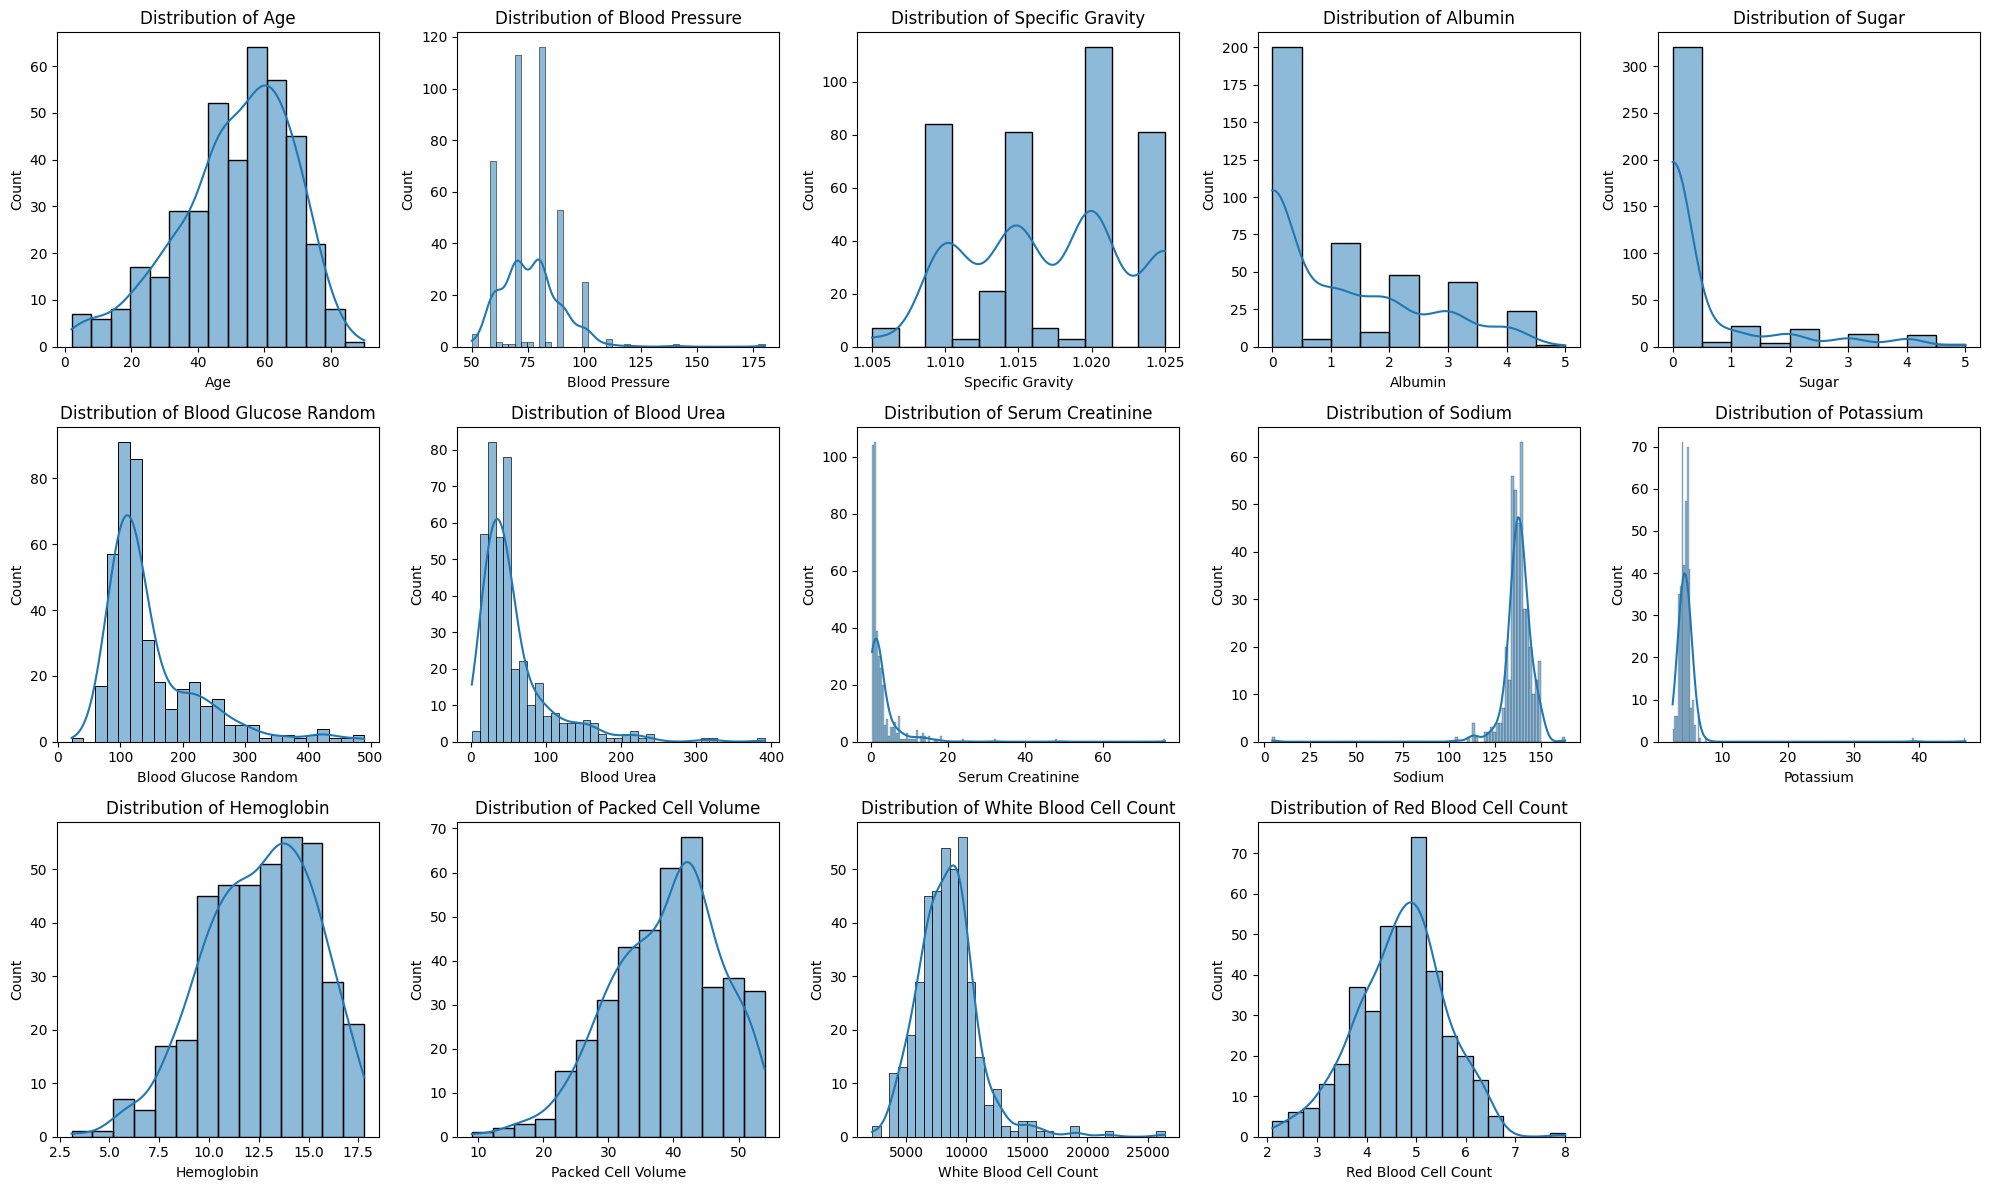

In [13]:
import matplotlib.pyplot as plt
num_plots = len(numerical_features)
num_cols = 5
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    if i < num_plots:
        sns.histplot(ckd_data[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')

for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Apply Capping to Handle Outliers

In [14]:
# Capping outliers based on clinical thresholds
ckd_data['Blood Glucose Random'] = ckd_data['Blood Glucose Random'].clip(upper=300)
ckd_data['Serum Creatinine'] = ckd_data['Serum Creatinine'].clip(upper=15)
ckd_data['Sodium'] = ckd_data['Sodium'].clip(lower=135, upper=145)
ckd_data['Potassium'] = ckd_data['Potassium'].clip(lower=3.5, upper=6.0)
ckd_data['White Blood Cell Count'] = ckd_data['White Blood Cell Count'].clip(upper=11000)
ckd_data['Hemoglobin'] = ckd_data['Hemoglobin'].clip(lower=7, upper=17)

# Check updated summary statistics
print(ckd_data[['Blood Glucose Random', 'Serum Creatinine', 'Sodium',
                'Potassium', 'White Blood Cell Count', 'Hemoglobin']].describe())


       Blood Glucose Random  Serum Creatinine      Sodium   Potassium  \
count            400.000000        400.000000  400.000000  400.000000   
mean             144.888000          2.743675  138.674500    4.395250   
std               62.790506          3.288659    3.484006    0.624045   
min               22.000000          0.400000  135.000000    3.500000   
25%              100.150000          0.900000  135.000000    3.900000   
50%              122.000000          1.310000  138.000000    4.390000   
75%              171.000000          2.800000  141.000000    4.900000   
max              300.000000         15.000000  145.000000    6.000000   

       White Blood Cell Count  Hemoglobin  
count              400.000000  400.000000  
mean              8205.850000   12.586000  
std               1901.153001    2.647358  
min               2200.000000    7.000000  
25%               6900.000000   10.775000  
50%               8380.000000   12.780000  
75%               9600.000000   14

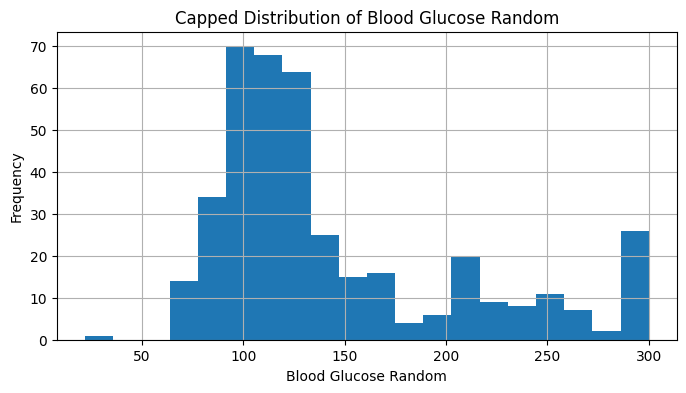

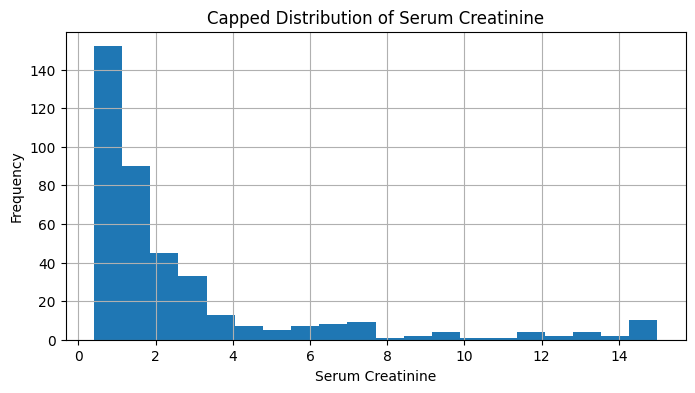

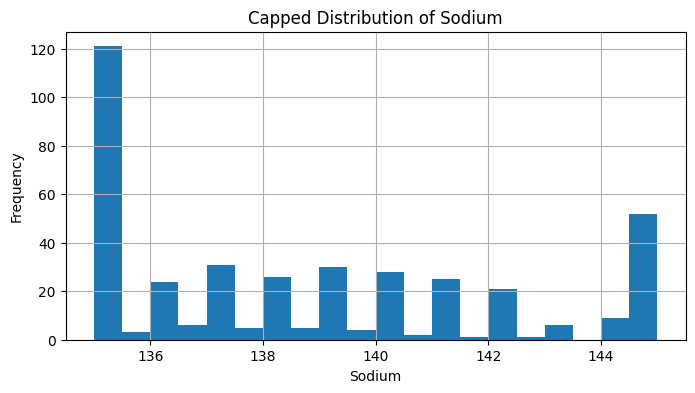

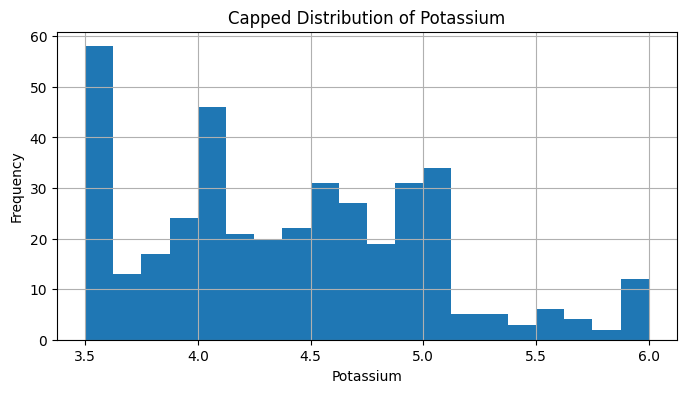

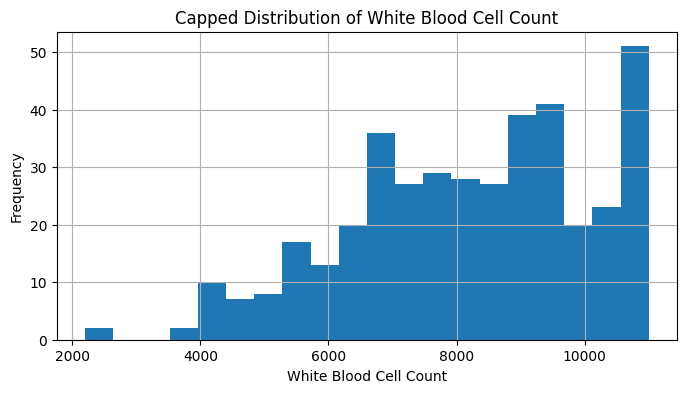

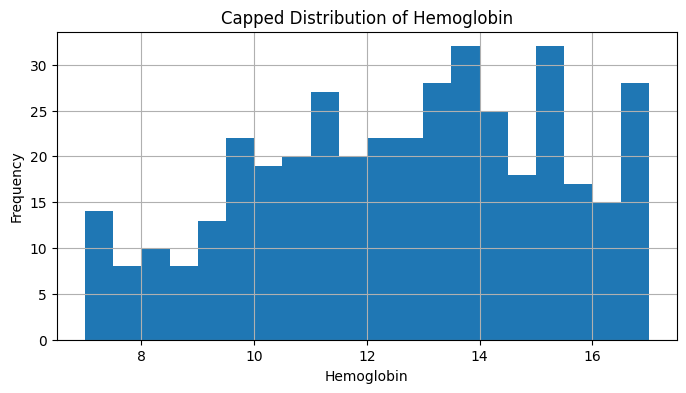

In [15]:
import matplotlib.pyplot as plt

# Features with capped outliers
capped_features = ['Blood Glucose Random', 'Serum Creatinine', 'Sodium',
                   'Potassium', 'White Blood Cell Count', 'Hemoglobin']

# Plot histograms
for feature in capped_features:
    plt.figure(figsize=(8, 4))
    ckd_data[feature].hist(bins=20)
    plt.title(f'Capped Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


In [16]:
# Confirm no extreme values remain
for feature in capped_features:
    print(f"{feature}: Min = {ckd_data[feature].min()}, Max = {ckd_data[feature].max()}")


Blood Glucose Random: Min = 22.0, Max = 300.0
Serum Creatinine: Min = 0.4, Max = 15.0
Sodium: Min = 135.0, Max = 145.0
Potassium: Min = 3.5, Max = 6.0
White Blood Cell Count: Min = 2200.0, Max = 11000.0
Hemoglobin: Min = 7.0, Max = 17.0


In [17]:
from sklearn.preprocessing import LabelEncoder

# List of categorical features to encode
categorical_features = ['Red Blood Cells', 'Pus Cell', 'Pus Cell Clumps', 'Bacteria',
                        'Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
                        'Appetite', 'Pedal Edema', 'Anemia']
# Apply Label Encoding for binary features
label_encoders =  {}
for feature in categorical_features:
    le = LabelEncoder()
    ckd_data[feature] = le.fit_transform(ckd_data[feature])
    label_encoders[feature] = le  # Save the encoder for inverse transformation if needed

# Verify encoding
print(ckd_data[categorical_features].head())


   Red Blood Cells  Pus Cell  Pus Cell Clumps  Bacteria  Hypertension  \
0                0         2                1         1             2   
1                0         2                1         1             1   
2                2         2                1         1             1   
3                2         1                2         1             2   
4                2         2                1         1             1   

   Diabetes Mellitus  Coronary Artery Disease  Appetite  Pedal Edema  Anemia  
0                  2                        1         1            1       1  
1                  1                        1         1            1       1  
2                  2                        1         2            1       2  
3                  1                        1         2            2       2  
4                  1                        1         1            1       1  


In [18]:
from sklearn.preprocessing import StandardScaler

# List of numerical features
numerical_features = ['Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar',
                      'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine',
                      'Sodium', 'Potassium', 'Hemoglobin', 'Packed Cell Volume',
                      'White Blood Cell Count', 'Red Blood Cell Count']
# Apply StandardScaler
scaler = StandardScaler()
ckd_data[numerical_features] = scaler.fit_transform(ckd_data[numerical_features])

# Verify scaling
print(ckd_data[numerical_features].describe())


                Age  Blood Pressure  Specific Gravity       Albumin  \
count  4.000000e+02    4.000000e+02      4.000000e+02  4.000000e+02   
mean   2.575717e-16    1.953993e-16      9.663381e-15  1.776357e-16   
std    1.001252e+00    1.001252e+00      1.001252e+00  1.001252e+00   
min   -2.889738e+00   -1.941388e+00     -2.223184e+00 -8.207259e-01   
25%   -5.460262e-01   -4.658889e-01     -7.617649e-01 -8.207259e-01   
50%    1.570873e-01    2.718608e-01     -2.137326e-01 -5.873441e-01   
75%    7.430152e-01    2.718608e-01      5.169771e-01  7.351526e-01   
max    2.266428e+00    7.649358e+00      1.430364e+00  3.068970e+00   

              Sugar  Blood Glucose Random    Blood Urea  Serum Creatinine  \
count  4.000000e+02          4.000000e+02  4.000000e+02      4.000000e+02   
mean  -5.329071e-17         -7.105427e-17  1.421085e-16     -3.552714e-17   
std    1.001252e+00          1.001252e+00  1.001252e+00      1.001252e+00   
min   -4.429358e-01         -1.959562e+00 -1.130352e

In [19]:
# Check the first few rows
print(ckd_data.head())


        Age  Blood Pressure  Specific Gravity   Albumin     Sugar  \
0 -0.194469        0.271861          0.516977 -0.042787 -0.442936   
1 -2.596774       -1.941388          0.516977  2.291031 -0.442936   
2  0.625830        0.271861         -1.309797  0.735153  2.417790   
3 -0.194469       -0.465889         -2.223184  2.291031 -0.442936   
4 -0.018691        0.271861         -1.309797  0.735153 -0.442936   

   Red Blood Cells  Pus Cell  Pus Cell Clumps  Bacteria  Blood Glucose Random  \
0                0         2                1         1             -0.380916   
1                0         2                1         1             -0.508483   
2                2         2                1         1              2.473403   
3                2         1                2         1             -0.444700   
4                2         2                1         1             -0.620105   

   ...  Packed Cell Volume  White Blood Cell Count  Red Blood Cell Count  \
0  ...            0.60

In [20]:
# Check data types
print(ckd_data.dtypes)

Age                        float64
Blood Pressure             float64
Specific Gravity           float64
Albumin                    float64
Sugar                      float64
Red Blood Cells              int64
Pus Cell                     int64
Pus Cell Clumps              int64
Bacteria                     int64
Blood Glucose Random       float64
Blood Urea                 float64
Serum Creatinine           float64
Sodium                     float64
Potassium                  float64
Hemoglobin                 float64
Packed Cell Volume         float64
White Blood Cell Count     float64
Red Blood Cell Count       float64
Hypertension                 int64
Diabetes Mellitus            int64
Coronary Artery Disease      int64
Appetite                     int64
Pedal Edema                  int64
Anemia                       int64
CKD Stage                    int64
dtype: object


In [21]:
# Define the list of features
numerical_features = ['Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar',
                      'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine',
                      'Sodium', 'Potassium', 'Hemoglobin', 'Packed Cell Volume',
                      'White Blood Cell Count', 'Red Blood Cell Count']

categorical_features = ['Red Blood Cells', 'Pus Cell', 'Pus Cell Clumps', 'Bacteria',
                        'Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
                        'Appetite', 'Pedal Edema', 'Anemia']

# Define transformations for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Define transformations for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [22]:
from sklearn.ensemble import RandomForestClassifier

# Define the full pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Verify the pipeline structure
print(pipeline)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Blood Pressure',
                                                   'Specific Gravity',
                                                   'Albumin', 'Sugar',
                                                   'Blood Glucose Random',
                                                   'Blood Urea',
                                                   'Serum Creatinine', 'Sodium',
                                                   'Potassium', 'Hemoglobin',
                                                   'Packed Cell Volu

In [23]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = ckd_data.drop('CKD Stage', axis=1)
y = ckd_data['CKD Stage']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)


In [24]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.975

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.93      0.96        28

    accuracy                           0.97        80
   macro avg       0.98      0.96      0.97        80
weighted avg       0.98      0.97      0.97        80


Confusion Matrix:
 [[52  0]
 [ 2 26]]


In [25]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,  # The full pipeline
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Optimize for accuracy
    n_jobs=-1,  # Use all processors for parallel computation
    verbose=2
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Display the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best Accuracy: 0.990625


In [26]:
# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test)

# Evaluate the optimized model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_optimized))
print("\nOptimized Classification Report:\n", classification_report(y_test, y_pred_optimized))
print("\nOptimized Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimized))


Optimized Model Accuracy: 0.975

Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.93      0.96        28

    accuracy                           0.97        80
   macro avg       0.98      0.96      0.97        80
weighted avg       0.98      0.97      0.97        80


Optimized Confusion Matrix:
 [[52  0]
 [ 2 26]]


                Feature  Importance
2      Specific Gravity    0.157439
10           Hemoglobin    0.120789
3               Albumin    0.117678
7      Serum Creatinine    0.106235
16    Red Blood Cells_2    0.104064
11   Packed Cell Volume    0.091120
14    Red Blood Cells_0    0.038302
28       Hypertension_2    0.032799
30  Diabetes Mellitus_1    0.025306
31  Diabetes Mellitus_2    0.025201


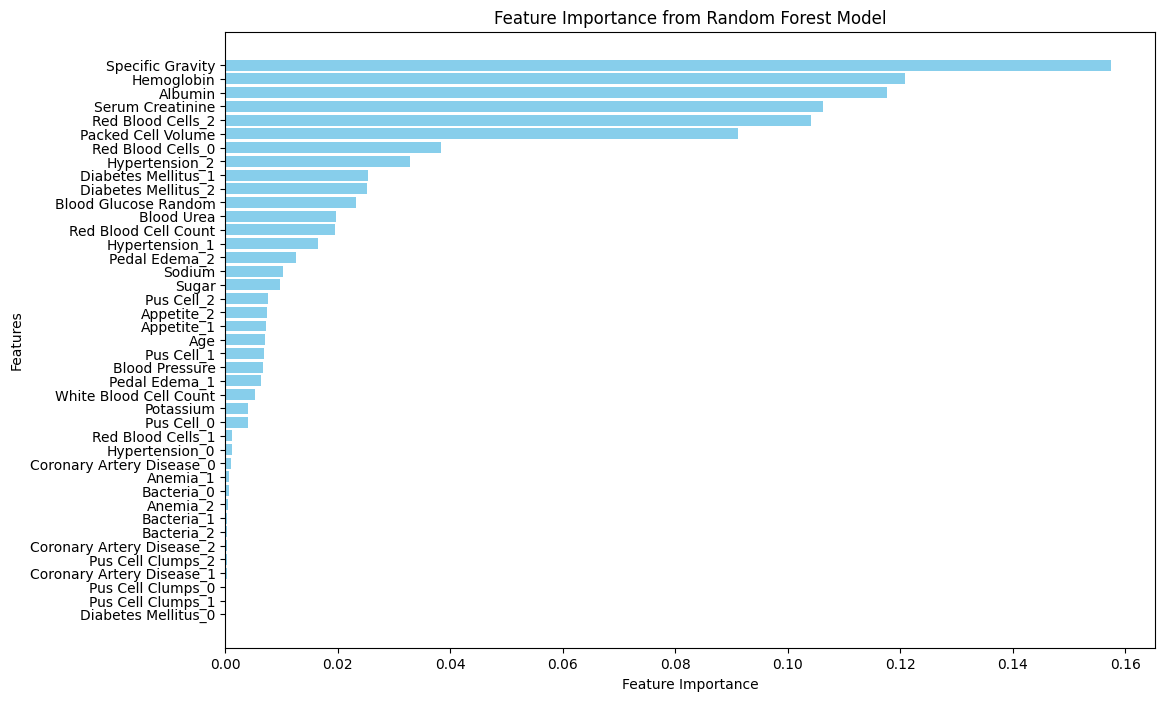

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature names from the pipeline's preprocessor
numerical_feature_names = numerical_features
categorical_feature_names = pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['encoder'] \
    .get_feature_names_out(categorical_features)

# Combine numerical and categorical feature names
all_feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Get feature importances from the trained model
importances = best_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest Model')
plt.show()


In [28]:
from sklearn.tree import DecisionTreeClassifier

# Update the pipeline with Decision Tree Classifier
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the pipeline
pipeline_dt.fit(X_train, y_train)

# Predict and evaluate
y_pred_dt = pipeline_dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.95

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96        52
           1       0.96      0.89      0.93        28

    accuracy                           0.95        80
   macro avg       0.95      0.94      0.94        80
weighted avg       0.95      0.95      0.95        80



In [29]:
from sklearn.neighbors import KNeighborsClassifier

# Update the pipeline with KNN Classifier
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))  # You can tune n_neighbors
])

# Train the pipeline
pipeline_knn.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = pipeline_knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.9625

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        52
           1       0.93      0.96      0.95        28

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# ANN model
ann_model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'),  # Input layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
ann_model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)

# Predict and evaluate
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype(int)
print("ANN Accuracy:", accuracy_score(y_test, y_pred_ann))
print("\nANN Classification Report:\n", classification_report(y_test, y_pred_ann))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7441 - loss: 0.5074
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9678 - loss: 0.2634 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9913 - loss: 0.1326 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0755 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9899 - loss: 0.0563 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0459 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9915 - loss: 0.0358 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9932 - loss: 0.0277 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9932 - loss: 0.0255 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9964 - loss: 0.0160 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9906 - loss: 0.0218 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9976 - los

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define parameter grid
param_grid_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit on training data
grid_search_dt.fit(X_train, y_train)

# Display best parameters and accuracy
print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best Accuracy for Decision Tree:", grid_search_dt.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Accuracy for Decision Tree: 0.971875


In [32]:
from sklearn.neighbors import KNeighborsClassifier

# Define parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit on training data
grid_search_knn.fit(X_train, y_train)

# Display best parameters and accuracy
print("Best Parameters for KNN:", grid_search_knn.best_params_)
print("Best Accuracy for KNN:", grid_search_knn.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best Accuracy for KNN: 0.975


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Split data (reused X_train and X_test)
X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the ANN model
def build_ann(learning_rate):
    model = Sequential([
        Dense(32, activation='relu', input_dim=X_train_ann.shape[1]),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the ANN with a tuned learning rate
learning_rates = [0.001, 0.01, 0.1]
best_accuracy = 0
best_lr = 0

for lr in learning_rates:
    ann_model = build_ann(learning_rate=lr)
    history = ann_model.fit(X_train_ann, y_train_ann, epochs=50, batch_size=10, verbose=0, validation_data=(X_val_ann, y_val_ann))
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Learning Rate: {lr}, Validation Accuracy: {val_accuracy}")
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_lr = lr

print("Best Learning Rate:", best_lr)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Learning Rate: 0.001, Validation Accuracy: 1.0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Learning Rate: 0.01, Validation Accuracy: 1.0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Learning Rate: 0.1, Validation Accuracy: 1.0
Best Learning Rate: 0.001


In [35]:
# Predict and evaluate the optimized Decision Tree
optimized_dt = grid_search_dt.best_estimator_
y_pred_dt = optimized_dt.predict(X_test)

print("Optimized Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nOptimized Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))


Optimized Decision Tree Accuracy: 0.975

Optimized Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        52
           1       1.00      0.93      0.96        28

    accuracy                           0.97        80
   macro avg       0.98      0.96      0.97        80
weighted avg       0.98      0.97      0.97        80



In [36]:
# Predict and evaluate the optimized KNN
optimized_knn = grid_search_knn.best_estimator_
y_pred_knn = optimized_knn.predict(X_test)

print("Optimized KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nOptimized KNN Classification Report:\n", classification_report(y_test, y_pred_knn))


Optimized KNN Accuracy: 0.975

Optimized KNN Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.96      0.96      0.96        28

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



In [37]:
# Build and train ANN with the best learning rate
ann_model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)

# Predict and evaluate ANN
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype(int)

print("Optimized ANN Accuracy:", accuracy_score(y_test, y_pred_ann))
print("\nOptimized ANN Classification Report:\n", classification_report(y_test, y_pred_ann))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6425 - loss: 0.6051   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9584 - loss: 0.3169 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9836 - loss: 0.1738 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9921 - loss: 0.1156 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9824 - loss: 0.0740 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9904 - loss: 0.0553 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.0388 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9968 - loss: 0.0331 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0224 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0326
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0171
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9994 - lo

In [38]:
import joblib

# Save the optimized Decision Tree model
joblib.dump(grid_search_dt.best_estimator_, 'optimized_decision_tree.pkl')

# Save the optimized KNN model
joblib.dump(grid_search_knn.best_estimator_, 'optimized_knn.pkl')

# Save the optimized Random Forest model
joblib.dump(grid_search.best_estimator_, 'optimized_random_forest.pkl')

# Save the optimized ANN model
ann_model.save('optimized_ann.keras')  # Use TensorFlow's save method for ANN
print("Optimized ANN model saved successfully in the native Keras format.")


Optimized ANN model saved successfully in the native Keras format.


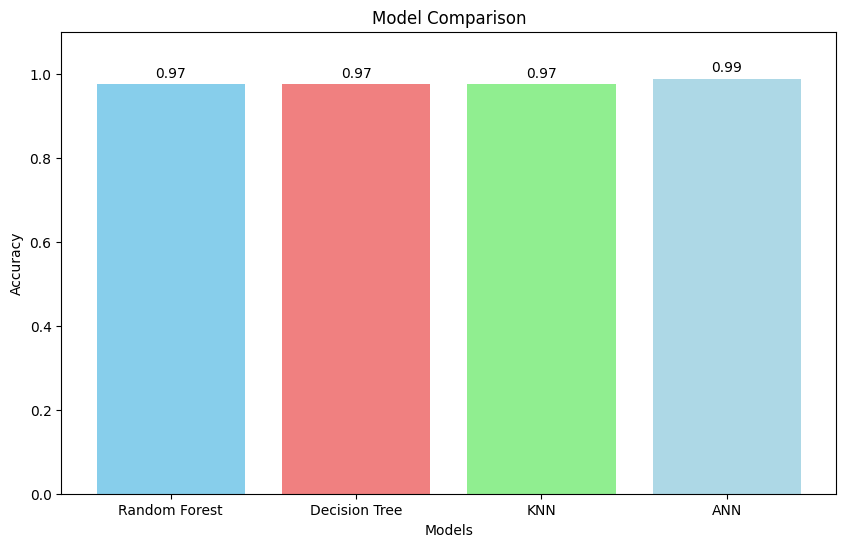

In [39]:

import matplotlib.pyplot as plt


# Assuming you have these variables from your model evaluations
rf_accuracy = accuracy_score(y_test, y_pred_optimized)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
ann_accuracy = accuracy_score(y_test, y_pred_ann)

models = ['Random Forest', 'Decision Tree', 'KNN', 'ANN']
accuracies = [rf_accuracy, dt_accuracy, knn_accuracy, ann_accuracy]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'lightblue'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison")

# Add accuracy values on top of each bar
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom') # Adjust 0.01 for better visual

plt.ylim(0, 1.1) # Ensure the accuracy labels fit
plt.show()

In [40]:
# Load the optimized Decision Tree model
optimized_dt = joblib.load('optimized_decision_tree.pkl')

# Load the optimized KNN model
optimized_knn = joblib.load('optimized_knn.pkl')

# Load the optimized Random Forest model
optimized_rf = joblib.load('optimized_random_forest.pkl')

# Load the optimized ANN model
from tensorflow.keras.models import load_model
optimized_ann = load_model('optimized_ann.keras')
print("Optimized ANN model loaded successfully.")



Optimized ANN model loaded successfully.


In [41]:
pip install lime

In [42]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Training data without target
    feature_names=X_train.columns,  # Feature names for explanation
    class_names=['Non-CKD', 'CKD'],  # Target class labels
    mode='classification'  # Classification mode
)


In [43]:
# Select an instance from the test set
instance_idx = 1  # Change the index to explain different instances
instance = X_test.iloc[instance_idx].values

# Explain the selected instance (e.g., for Random Forest)
lime_explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=lambda x: optimized_dt.predict_proba(x)  # Use predict_proba for Random Forest
)

# Show explanation
lime_explanation.show_in_notebook(show_table=True)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [44]:
import numpy as np

# Adjust predict function for ANN
def predict_fn(x):
    probs = ann_model.predict(x).reshape(-1, 1)  # Class 1 probabilities (CKD)
    return np.hstack([1 - probs, probs])  # Combine probabilities for class 0 and class 1

# Explain the selected instance for ANN
lime_explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_fn  # Use the adjusted predict function
)

# Show explanation
lime_explanation.show_in_notebook(show_table=True)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [44]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# Load the models
try:
    rf_model = joblib.load('optimized_random_forest.pkl')
    ann_model = load_model('optimized_ann.keras')
except FileNotFoundError:
    print("Error: Model files not found. Please ensure 'optimized_random_forest.pkl' and 'optimized_ann.keras' are in the same directory as this script.")
    exit()


# Function to predict CKD
def predict_ckd(features, model_type='RandomForest'):
    features_array = np.array(features).reshape(1, -1)
    if model_type == 'RandomForest':
        probabilities = rf_model.predict_proba(features_array)
        prediction = rf_model.predict(features_array)
    elif model_type == 'ANN':
        probabilities = ann_model.predict(features_array).flatten()
        probabilities = np.array([1 - probabilities[0], probabilities[0]])
        prediction = (probabilities[1] > 0.5).astype(int)
    confidence = max(probabilities) * 100  # Confidence score in percentage
    return 'CKD' if prediction == 1 else 'Non-CKD', confidence

def get_user_input():
    """Collects user inputs for patient features."""
    print("Please enter the patient details:")
    age = int(input("Age (years): "))
    bp = int(input("Blood Pressure (mmHg): "))
    sg = float(input("Specific Gravity: "))
    al = int(input("Albumin: "))
    su = int(input("Sugar: "))
    rbc = int(input("Red Blood Cells (0 for Not Normal, 1 for Normal): "))
    pc = int(input("Pus Cell (0 for Abnormal, 1 for Normal): "))
    pcc = int(input("Pus Cell Clumps (0 for Not Present, 1 for Present): "))
    ba = int(input("Bacteria (0 for Not Present, 1 for Present): "))
    bgr = float(input("Blood Glucose Random (mg/dL): "))
    bu = float(input("Blood Urea (mg/dL): "))
    sc = float(input("Serum Creatinine (mg/dL): "))
    sodium = float(input("Sodium (mmol/L): "))
    potassium = float(input("Potassium (mmol/L): "))
    hemo = float(input("Hemoglobin (g/dL): "))
    pcv = float(input("Packed Cell Volume (%): "))
    wbcc = float(input("White Blood Cell Count (cells/μL): "))
    rbcc = float(input("Red Blood Cell Count (million/μL): "))
    htn = int(input("Hypertension (0 for No, 1 for Yes): "))
    dm = int(input("Diabetes Mellitus (0 for No, 1 for Yes): "))
    cad = int(input("Coronary Artery Disease (0 for No, 1 for Yes): "))
    appet = int(input("Appetite (0 for Poor, 1 for Good): "))
    pe = int(input("Pedal Edema (0 for No, 1 for Yes): "))
    ane = int(input("Anemia (0 for No, 1 for Yes): "))

    return [
        age, bp, sg, al, su, rbc, pc, pcc, ba, bgr, bu, sc, sodium, potassium,
        hemo, pcv, wbcc, rbcc, htn, dm, cad, appet, pe, ane
    ]

# Main part of the script
if __name__ == "__main__":
    patient_features = get_user_input()
    model_type = input("Enter Model Type (RandomForest or ANN): ")

    if model_type not in ['RandomForest', 'ANN']:
         print("Invalid model type. Please choose between 'RandomForest' or 'ANN'.")
         exit()

    result, confidence = predict_ckd(patient_features, model_type)
    print(f"Prediction: {result}")
    print(f"Confidence Score: {confidence:.2f}%")

Please enter the patient details:
Age (years): 24
Blood Pressure (mmHg): 3
Specific Gravity: 4
Albumin: 3
Sugar: 23
Red Blood Cells (0 for Not Normal, 1 for Normal): 1
Pus Cell (0 for Abnormal, 1 for Normal): 1
Pus Cell Clumps (0 for Not Present, 1 for Present): 1
Bacteria (0 for Not Present, 1 for Present): 0
Blood Glucose Random (mg/dL): 4
Blood Urea (mg/dL): 1
Serum Creatinine (mg/dL): 3
Sodium (mmol/L): 4
Potassium (mmol/L): 6
Hemoglobin (g/dL): 4
Packed Cell Volume (%): 6
White Blood Cell Count (cells/μL): 3
Red Blood Cell Count (million/μL): 5
Hypertension (0 for No, 1 for Yes): 1
Diabetes Mellitus (0 for No, 1 for Yes): 1
Coronary Artery Disease (0 for No, 1 for Yes): 1
Appetite (0 for Poor, 1 for Good): 1
Pedal Edema (0 for No, 1 for Yes): 1
Anemia (0 for No, 1 for Yes): 1
Enter Model Type (RandomForest or ANN): ANN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction: Non-CKD
Confidence Score: 100.00%


In [45]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from lime.lime_tabular import LimeTabularExplainer
import pandas as pd

# Load the models
try:
    rf_model = joblib.load('optimized_random_forest.pkl')
    ann_model = load_model('optimized_ann.keras')
except FileNotFoundError:
    print("Error: Model files not found. Please ensure 'optimized_random_forest.pkl' and 'optimized_ann.keras' are in the same directory as this script.")
    exit()

# Load the original data (or create if not available)
try:
    # Load data from csv, assuming it's the same data used for training
    file_path = 'chronic_kidney_disease (1).csv'  # Replace with your actual file
    ckd_data = pd.read_csv(file_path)
    # Rename columns
    column_mapping = {
        'age': 'Age',
        'bp': 'Blood Pressure',
        'sg': 'Specific Gravity',
        'al': 'Albumin',
        'su': 'Sugar',
        'rbc': 'Red Blood Cells',
        'pc': 'Pus Cell',
        'pcc': 'Pus Cell Clumps',
        'ba': 'Bacteria',
        'bgr': 'Blood Glucose Random',
        'bu': 'Blood Urea',
        'sc': 'Serum Creatinine',
        'sod': 'Sodium',
        'pot': 'Potassium',
        'hemo': 'Hemoglobin',
        'pcv': 'Packed Cell Volume',
        'wbcc': 'White Blood Cell Count',
        'rbcc': 'Red Blood Cell Count',
        'htn': 'Hypertension',
        'dm': 'Diabetes Mellitus',
        'cad': 'Coronary Artery Disease',
        'appet': 'Appetite',
        'pe': 'Pedal Edema',
        'ane': 'Anemia',
        'class': 'CKD Stage'
    }
    ckd_data = ckd_data.rename(columns=column_mapping)
    ckd_data['CKD Stage'] = ckd_data['CKD Stage'].replace('ckd\t', 'ckd')
    ckd_data['Diabetes Mellitus'] = ckd_data['Diabetes Mellitus'].replace('\tno', 'no')
    categorical_features = ckd_data.select_dtypes(include=['object']).columns
    numerical_features = ckd_data.select_dtypes(include=['float', 'int']).columns

    from sklearn.impute import KNNImputer

    # Initialize KNN Imputer
    knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

    # Apply KNN Imputation to numerical features
    ckd_data[numerical_features] = knn_imputer.fit_transform(ckd_data[numerical_features])

    # Apply KNN Imputation to categorical features (converted to numeric temporarily)
    categorical_features_encoded = ckd_data[categorical_features].apply(lambda x: x.astype('category').cat.codes)
    ckd_data[categorical_features] = knn_imputer.fit_transform(categorical_features_encoded).astype(int)

    from sklearn.preprocessing import LabelEncoder
    # List of categorical features to encode
    categorical_features = ['Red Blood Cells', 'Pus Cell', 'Pus Cell Clumps', 'Bacteria',
                            'Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
                            'Appetite', 'Pedal Edema', 'Anemia']
    # Apply Label Encoding for binary features
    label_encoders = {}
    for feature in categorical_features:
        le = LabelEncoder()
        ckd_data[feature] = le.fit_transform(ckd_data[feature])
        label_encoders[feature] = le  # Save the encoder for inverse transformation if needed

    from sklearn.preprocessing import StandardScaler

    # List of numerical features
    numerical_features = ['Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar',
                          'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine',
                          'Sodium', 'Potassium', 'Hemoglobin', 'Packed Cell Volume',
                          'White Blood Cell Count', 'Red Blood Cell Count']
    # Apply StandardScaler
    scaler = StandardScaler()
    ckd_data[numerical_features] = scaler.fit_transform(ckd_data[numerical_features])
    X_train = ckd_data.drop('CKD Stage', axis=1)

except FileNotFoundError:
     print("Error: Data file not found. Ensure 'chronic_kidney_disease (1).csv' is in the same directory as the script")
     exit()


# Function to predict CKD
def predict_ckd(features, model_type='RandomForest'):
    features_array = np.array(features).reshape(1, -1)
    if model_type == 'RandomForest':
        probabilities = rf_model.predict_proba(features_array)
        prediction = rf_model.predict(features_array)
    elif model_type == 'ANN':
        probabilities = ann_model.predict(features_array).flatten()
        probabilities = np.array([1 - probabilities[0], probabilities[0]])
        prediction = (probabilities[1] > 0.5).astype(int)
    confidence = max(probabilities) * 100  # Confidence score in percentage
    return 'CKD' if prediction == 1 else 'Non-CKD', confidence

def get_user_input():
    """Collects user inputs for patient features."""
    print("Please enter the patient details:")
    age = int(input("Age (years): "))
    bp = int(input("Blood Pressure (mmHg): "))
    sg = float(input("Specific Gravity: "))
    al = int(input("Albumin: "))
    su = int(input("Sugar: "))
    rbc = int(input("Red Blood Cells (0 for Not Normal, 1 for Normal): "))
    pc = int(input("Pus Cell (0 for Abnormal, 1 for Normal): "))
    pcc = int(input("Pus Cell Clumps (0 for Not Present, 1 for Present): "))
    ba = int(input("Bacteria (0 for Not Present, 1 for Present): "))
    bgr = float(input("Blood Glucose Random (mg/dL): "))
    bu = float(input("Blood Urea (mg/dL): "))
    sc = float(input("Serum Creatinine (mg/dL): "))
    sodium = float(input("Sodium (mmol/L): "))
    potassium = float(input("Potassium (mmol/L): "))
    hemo = float(input("Hemoglobin (g/dL): "))
    pcv = float(input("Packed Cell Volume (%): "))
    wbcc = float(input("White Blood Cell Count (cells/μL): "))
    rbcc = float(input("Red Blood Cell Count (million/μL): "))
    htn = int(input("Hypertension (0 for No, 1 for Yes): "))
    dm = int(input("Diabetes Mellitus (0 for No, 1 for Yes): "))
    cad = int(input("Coronary Artery Disease (0 for No, 1 for Yes): "))
    appet = int(input("Appetite (0 for Poor, 1 for Good): "))
    pe = int(input("Pedal Edema (0 for No, 1 for Yes): "))
    ane = int(input("Anemia (0 for No, 1 for Yes): "))

    return [
        age, bp, sg, al, su, rbc, pc, pcc, ba, bgr, bu, sc, sodium, potassium,
        hemo, pcv, wbcc, rbcc, htn, dm, cad, appet, pe, ane
    ]


def explain_prediction(features, model_type, feature_names, X_train):
     """Explains the prediction using LIME."""
     features_array = np.array(features).reshape(1, -1)
     explainer = LimeTabularExplainer(
        training_data=X_train.values,  # Training data without target
        feature_names=feature_names,  # Feature names for explanation
        class_names=['Non-CKD', 'CKD'],  # Target class labels
        mode='classification'  # Classification mode
     )
     if model_type == 'RandomForest':
          lime_explanation = explainer.explain_instance(
            data_row=features_array[0],
            predict_fn=lambda x: rf_model.predict_proba(x)
          )
     elif model_type == 'ANN':
          def predict_fn(x):
            probs = ann_model.predict(x).reshape(-1, 1)  # Class 1 probabilities (CKD)
            return np.hstack([1 - probs, probs])
          lime_explanation = explainer.explain_instance(
              data_row=features_array[0],
              predict_fn=predict_fn
          )
     print("LIME Explanation:")
     for feature, importance in lime_explanation.as_list():
            print(f"  {feature}: {importance:.4f}")


# Main part of the script
if __name__ == "__main__":
    patient_features = get_user_input()
    model_type = input("Enter Model Type (RandomForest or ANN): ")
    if model_type not in ['RandomForest', 'ANN']:
         print("Invalid model type. Please choose between 'RandomForest' or 'ANN'.")
         exit()
    result, confidence = predict_ckd(patient_features, model_type)
    print(f"Prediction: {result}")
    print(f"Confidence Score: {confidence:.2f}%")
    # Assuming numerical features are the same
    feature_names = ['Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar',
            'Red Blood Cells', 'Pus Cell', 'Pus Cell Clumps', 'Bacteria',
            'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine',
            'Sodium', 'Potassium', 'Hemoglobin', 'Packed Cell Volume',
            'White Blood Cell Count', 'Red Blood Cell Count',
            'Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
            'Appetite', 'Pedal Edema', 'Anemia']
    explain_prediction(patient_features, model_type, feature_names, X_train)

Error: Data file not found. Ensure 'chronic_kidney_disease (1).csv' is in the same directory as the script
Please enter the patient details:
Age (years): 24
Blood Pressure (mmHg): 120
Specific Gravity: 2
Albumin: 3
Sugar: 45
Red Blood Cells (0 for Not Normal, 1 for Normal): 1
Pus Cell (0 for Abnormal, 1 for Normal): 1
Pus Cell Clumps (0 for Not Present, 1 for Present): 1
Bacteria (0 for Not Present, 1 for Present): 1
Blood Glucose Random (mg/dL): 45
Blood Urea (mg/dL): 67
Serum Creatinine (mg/dL): 3
Sodium (mmol/L): 4
Potassium (mmol/L): 3
Hemoglobin (g/dL): 4
Packed Cell Volume (%): 3
White Blood Cell Count (cells/μL): 4
Red Blood Cell Count (million/μL): 32
Hypertension (0 for No, 1 for Yes): 45
Diabetes Mellitus (0 for No, 1 for Yes): 1
Coronary Artery Disease (0 for No, 1 for Yes): 1
Appetite (0 for Poor, 1 for Good): 1
Pedal Edema (0 for No, 1 for Yes): 1
Anemia (0 for No, 1 for Yes): 1
Enter Model Type (RandomForest or ANN): ANN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: N

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


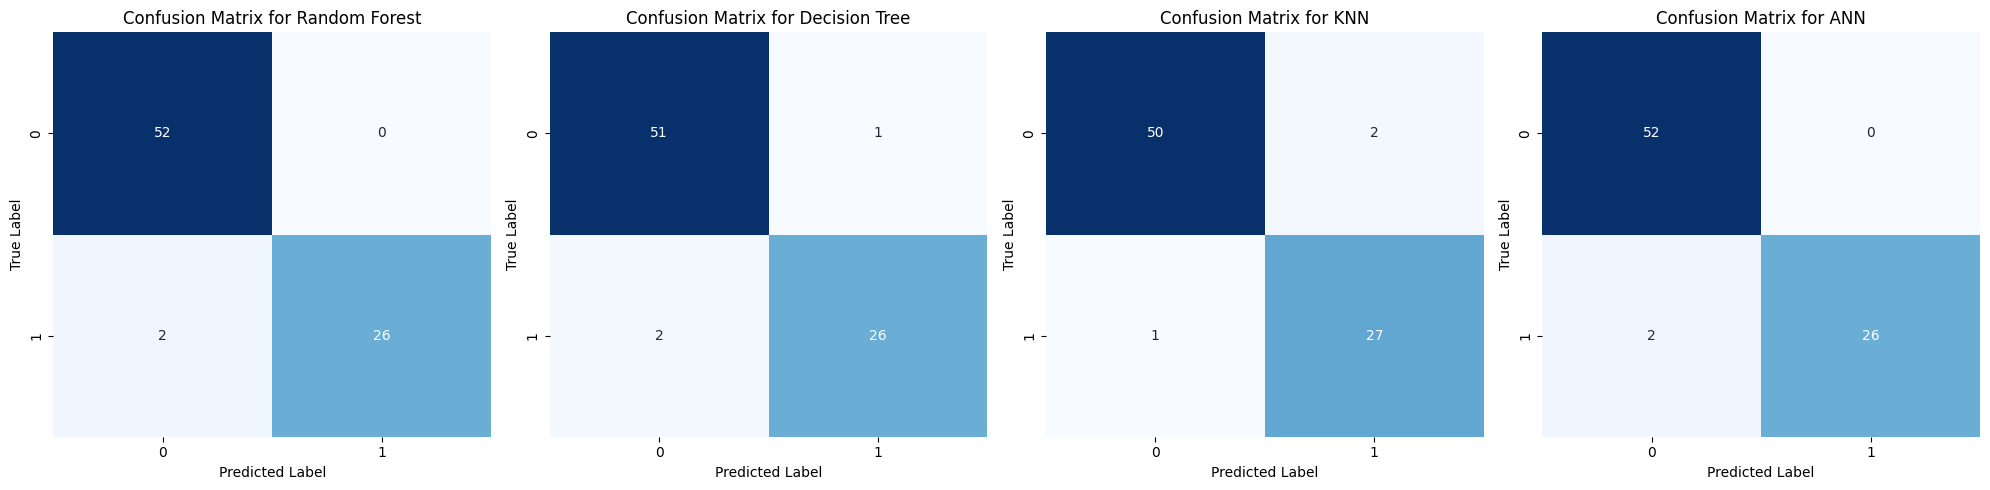

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

# Load data
file_path = '/content/drive/MyDrive/Chronic kidney disease/chronic_kidney_disease (1).csv'
ckd_data = pd.read_csv(file_path)

# Rename columns
column_mapping = {
    'age': 'Age',
    'bp': 'Blood Pressure',
    'sg': 'Specific Gravity',
    'al': 'Albumin',
    'su': 'Sugar',
    'rbc': 'Red Blood Cells',
    'pc': 'Pus Cell',
    'pcc': 'Pus Cell Clumps',
    'ba': 'Bacteria',
    'bgr': 'Blood Glucose Random',
    'bu': 'Blood Urea',
    'sc': 'Serum Creatinine',
    'sod': 'Sodium',
    'pot': 'Potassium',
    'hemo': 'Hemoglobin',
    'pcv': 'Packed Cell Volume',
    'wbcc': 'White Blood Cell Count',
    'rbcc': 'Red Blood Cell Count',
    'htn': 'Hypertension',
    'dm': 'Diabetes Mellitus',
    'cad': 'Coronary Artery Disease',
    'appet': 'Appetite',
    'pe': 'Pedal Edema',
    'ane': 'Anemia',
    'class': 'CKD Stage'
}
ckd_data = ckd_data.rename(columns=column_mapping)

# Clean target variable
ckd_data['CKD Stage'] = ckd_data['CKD Stage'].replace('ckd\t', 'ckd')
ckd_data['Diabetes Mellitus'] = ckd_data['Diabetes Mellitus'].replace('\tno', 'no')

# Identify categorical and numerical features
categorical_features = ckd_data.select_dtypes(include=['object']).columns
numerical_features = ckd_data.select_dtypes(include=['float', 'int']).columns

# Impute missing values using KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
ckd_data[numerical_features] = knn_imputer.fit_transform(ckd_data[numerical_features])
categorical_features_encoded = ckd_data[categorical_features].apply(lambda x: x.astype('category').cat.codes)
ckd_data[categorical_features] = knn_imputer.fit_transform(categorical_features_encoded).astype(int)

# Label Encode categorical features
from sklearn.preprocessing import LabelEncoder
categorical_features = ['Red Blood Cells', 'Pus Cell', 'Pus Cell Clumps', 'Bacteria',
                        'Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
                        'Appetite', 'Pedal Edema', 'Anemia']
for feature in categorical_features:
    le = LabelEncoder()
    ckd_data[feature] = le.fit_transform(ckd_data[feature])

# Scale numerical features
scaler = StandardScaler()
ckd_data[numerical_features] = scaler.fit_transform(ckd_data[numerical_features])

# Split data into training and testing sets
X = ckd_data.drop('CKD Stage', axis=1)
y = ckd_data['CKD Stage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define models
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier(random_state=42))])
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', DecisionTreeClassifier(random_state=42))])
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', KNeighborsClassifier())])

# Train models
rf_pipeline.fit(X_train, y_train)
dt_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)

# ANN model
ann_model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'),  # Input layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer
])

ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0)

# Function to create confusion matrix plot
def plot_confusion_matrices(y_true, y_preds, model_names):
    num_models = len(y_preds)
    fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5))
    axes = axes.flatten() if num_models > 1 else [axes]

    for i, (y_pred, model_name) in enumerate(zip(y_preds, model_names)):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'Confusion Matrix for {model_name}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

# Make predictions
rf_y_pred = rf_pipeline.predict(X_test)
dt_y_pred = dt_pipeline.predict(X_test)
knn_y_pred = knn_pipeline.predict(X_test)
ann_y_pred = (ann_model.predict(X_test) > 0.5).astype(int).flatten()

# Plot confusion matrices side by side
y_preds = [rf_y_pred, dt_y_pred, knn_y_pred, ann_y_pred]
model_names = ['Random Forest', 'Decision Tree', 'KNN', 'ANN']
plot_confusion_matrices(y_test, y_preds, model_names)